In [46]:
# bibliotecas e formatos
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots
import nbformat

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

#estilo plt
plt.style.use("ggplot")

#formato numerico pandas
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Funções e classes


In [4]:
#Extração
df = pd.read_csv('Base_Dados - Walmart.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,4.00,192.01,8.68
6431,45,05-10-2012,733455.07,0,64.89,3.98,192.17,8.67
6432,45,12-10-2012,734464.36,0,54.47,4.00,192.33,8.67
6433,45,19-10-2012,718125.53,0,56.47,3.97,192.33,8.67


In [5]:
# criar cluster com quartis
classe_loja = df.groupby(by=['Store'])[['Weekly_Sales']].sum().reset_index()
classe_loja['Classe'] = pd.qcut(classe_loja['Weekly_Sales'],q=4,labels=['Pequeno','Médio','Grande','Super'])

df = pd.merge(df,classe_loja[['Store','Classe']],on='Store',how='left')
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Classe
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11,Super
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11,Super
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11,Super
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11,Super
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11,Super


### Loja 1

In [6]:
#agrupar e agregar base por loja
df1 = df
df1.Date = pd.to_datetime(df1.Date,dayfirst=True)
df1 = df1[df1['Store']==1]
df1['month'] = df.Date.dt.month
df1['year'] = df.Date.dt.year
df1 = df1.groupby(by=['year','month']).agg(sum_faturamento=('Weekly_Sales','sum')).reset_index()
df1['Data'] = df1.year.astype('str') +'-'+ df1.month.astype('str') + '-1'
df1['Data'] = pd.to_datetime(df1['Data'])
df1.drop(['year','month'],axis=1,inplace=True)
df1.set_index('Data', inplace=True)

df1.head(50)

C:\Users\walte\AppData\Local\Temp\ipykernel_22908\878878208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = df.Date.dt.month
C:\Users\walte\AppData\Local\Temp\ipykernel_22908\878878208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year'] = df.Date.dt.year


,sum_faturamento
Data,
2010-02-01,6307344.10
2010-03-01,5871293.98
2010-04-01,7422801.92
2010-05-01,5929938.64
2010-06-01,6084081.46
2010-07-01,7244483.04
2010-08-01,6075952.95
2010-09-01,5829793.92
2010-10-01,7150641.75


In [48]:
df1.describe()

,sum_faturamento
count,33.00
mean,6739479.06
std,904376.59
min,5480050.97
25%,6122381.52
50%,6399887.57
75%,7244483.04
max,9032594.71


In [7]:
fig = px.line(df1, x=df1.index, y="sum_faturamento",  title='Net Sales time series loja 1', markers=True)
fig.update_traces(textposition="bottom right")
fig.show()

In [8]:
#treino e teste
train_size = int(len(df1)*0.8)
train = df1[0:train_size]
test = df1[train_size:]
train.shape,test.shape

((26, 1), (7, 1))

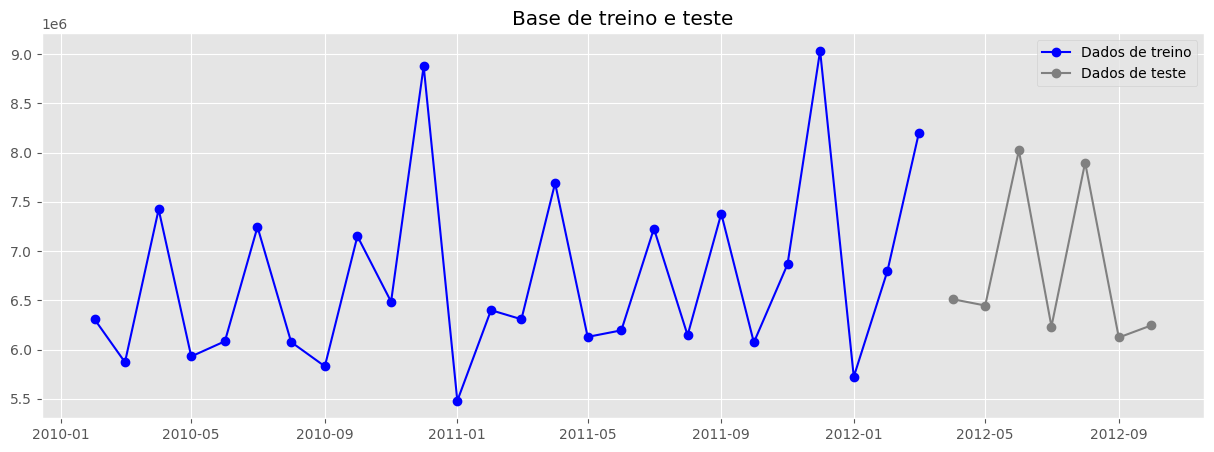

In [20]:
plt.figure(figsize=(15,5))
plt.title('Base de treino e teste')
plt.plot(train,color='blue',marker='o',label='Dados de treino')
plt.plot(test,color='grey',marker='o',label='Dados de teste')
plt.legend();

In [36]:
#configurando modelo
model = auto_arima(train, 
                   seasonal=True,
                   m=8
                   ) 
print(model.summary())

                                SARIMAX Results                                
Dep. Variable:                       y   No. Observations:                   26
Model:             SARIMAX(0, 1, 0, 8)   Log Likelihood                -275.885
Date:                 Mon, 02 Sep 2024   AIC                            555.771
Time:                         22:24:25   BIC                            557.552
Sample:                     02-01-2010   HQIC                           556.017
                          - 03-01-2012                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.029e+05   3.15e+05      0.963      0.336   -3.14e+05     9.2e+05
sigma2      1.203e+12   4.01e+11      2.998      0.003    4.17e+11    1.99e+12
Ljung-Box (L1) (Q):                   4.86  

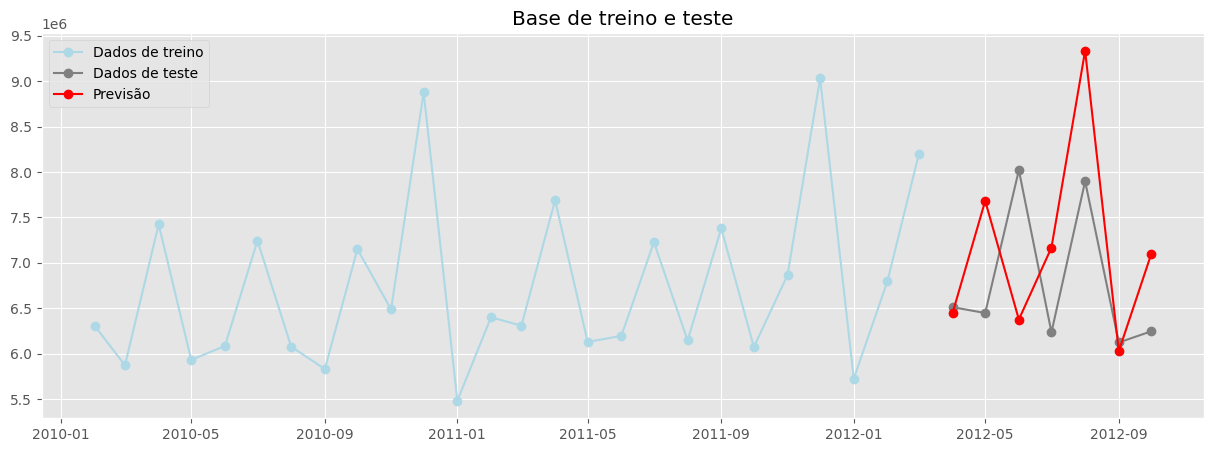

In [39]:
#realizando inferencia
n_periods = 7
output = model.predict(n_periods)

plt.figure(figsize=(15,5))
plt.title('Base de treino e teste')
plt.plot(train,color='lightblue',marker='o',label='Dados de treino')
plt.plot(test,color='grey',marker='o',label='Dados de teste')
plt.plot(output,color='Red',marker='o',label='Previsão')
plt.legend();



In [45]:
#calculo de erros e validação
mae = round(mean_absolute_error(test, output),2)
mse = round(mean_squared_error(test, output),2)
rmse = round(np.sqrt(mse),2)
r2 = round(r2_score(test, output),2)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}')

MAE: 895308.63, MSE: 1131181255569.23, RMSE: 1063570.05, R2: -0.99


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   33
Model:             SARIMAX(2, 0, 2)x(0, 1, [], 12)   Log Likelihood                -311.769
Date:                             Mon, 02 Sep 2024   AIC                            635.538
Time:                                     22:44:06   BIC                            641.805
Sample:                                 02-01-2010   HQIC                           636.898
                                      - 10-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.653e+05    7.2e+05      1.340      0.180   -4.47e+05    2.38e+06
ar.L1         -1.1273      

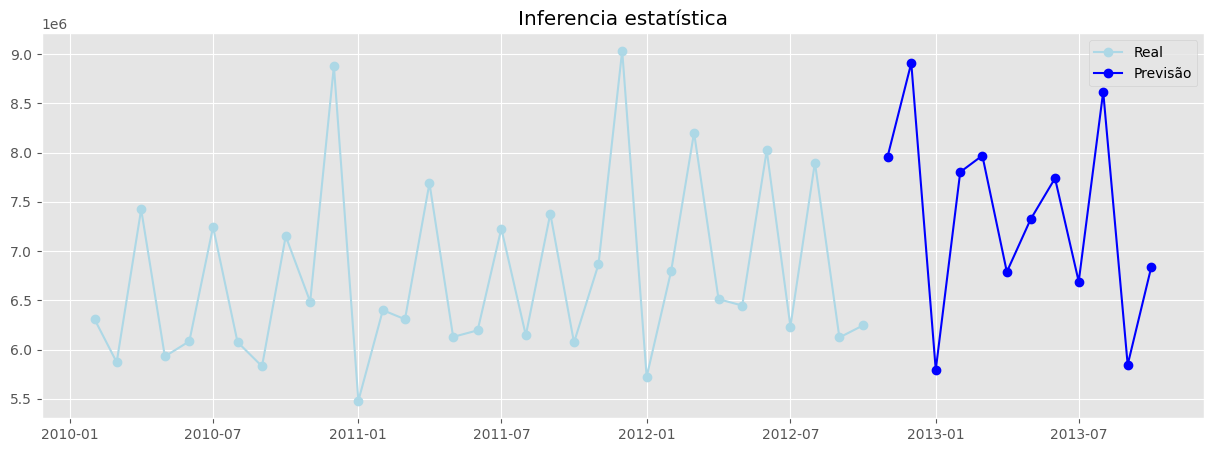

In [51]:
#projeção real
#configurando modelo
model = auto_arima(df1, 
                   seasonal=True,
                   m=12
                   ) 
print(model.summary())


#realizando inferencia
n_periods = 12
previsao = model.predict(n_periods)

plt.figure(figsize=(15,5))
plt.title('Inferencia estatística')
plt.plot(df1,color='lightblue',marker='o',label='Real')
plt.plot(previsao,color='blue',marker='o',label='Previsão')
plt.legend();
